# Анализ показателя Retention в ленте новостей.

Наше приложение - лента новостей. В наших данных использования ленты новостей есть два типа юзеров: те, кто пришел через платный трафик - `ads`, и те, кто пришел через органические каналы - `organic`.
У нас есть два задания, связанные с расчетом показателя Retention.

1. Ваша задача — проанализировать и сравнить Retention "органических" и "рекламных" пользователей . Решением этой задачи будет ответ на вопрос: **отличается ли характер использования приложения у этих групп пользователей?**


2. Маркетологи `7 ноября 2023 года` запустили массивную рекламную кампанию, в результате в приложение пришло довольно много новых пользователей. Однако у нас есть сомнение в качестве трафика. Решением этой задачи будет ответ на вопрос: **что стало с рекламными пользователями в дальнейшем, как часто они продолжают пользоваться приложением?**

## Задание 1. Сравнение Retention "органических" и "рекламных" пользователей.

In [1]:
#импортируем библиотеки

import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
sns.set(rc={'figure.figsize': (15, 7)})
pd.options.display.float_format ='{:,.0f}'.format

In [2]:
#параметры соединения - нужны, чтобы подключиться к нужной схеме данных
connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator',
              'user':'student',
              'password':'dpo_python_2020'}

В решении задачи мы будем сравнивать `retention 1, 7, 14, 21 и 30 дня` органических и рекламных пользователей. Поэтому возьмем пользователей, у которых уже набралось 30 дней в нашем приложении.  

In [3]:
#формулируем запрос

q = """
SELECT start_date, action_date, number_day, source, count_users, max_users_cohort, 
       ROUND(count_users / max_users_cohort * 100 ,1) AS retention_rate
FROM
(
    SELECT start_date, action_date, number_day, source, count_users,
           MAX(count_users) OVER(PARTITION BY start_date, source) AS max_users_cohort
    FROM (
        SELECT start_date, action_date, (action_date - start_date) as number_day,  source, COUNT(DISTINCT user_id) AS count_users
        FROM (
            SELECT user_id, source, MIN(toDate(time)) AS start_date
            FROM simulator_20231113.feed_actions
            GROUP BY user_id, source) AS a1
        JOIN
            (SELECT user_id, toDate(time) AS action_date
            FROM simulator_20231113.feed_actions) AS a2 USING(user_id)
        GROUP BY start_date, action_date, source, number_day 
        HAVING start_date >= yesterday() - 44 AND start_date<= yesterday() - 30 AND number_day <= 30
        ORDER BY start_date) AS a3)
ORDER BY start_date, action_date        
"""

# сохраняем запрос в переменной df
df = ph.read_clickhouse(q, connection=connection)

In [4]:
df.head(10)

,start_date,action_date,number_day,source,count_users,max_users_cohort,retention_rate
0,2023-11-10,2023-11-10,0,organic,1093,1093,100
1,2023-11-10,2023-11-10,0,ads,947,947,100
2,2023-11-10,2023-11-11,1,organic,472,1093,43
3,2023-11-10,2023-11-11,1,ads,357,947,38
4,2023-11-10,2023-11-12,2,organic,456,1093,42
5,2023-11-10,2023-11-12,2,ads,345,947,36
6,2023-11-10,2023-11-13,3,ads,300,947,32
7,2023-11-10,2023-11-13,3,organic,434,1093,40
8,2023-11-10,2023-11-14,4,organic,433,1093,40
9,2023-11-10,2023-11-14,4,ads,341,947,36


Опишем данные:
- `start_date` - первый день пользователя в нашем приложения(первый день когорты)
- `action_date`- дата появления пользователей в нашем приложении 
- `number_day` - номер дня пользователей в приложении
- `source` - источник привлечения пользователей
- `count_users` - количество пользователей из когорты в конкретный день
- `max_users_cohort` - максимальное количество пользователей для каждой когорты пользователей(в 0 день)
- `retention_rate`- показатель retention для каждой когорты в разрезе источника привлечения пользователей

In [5]:
#приведем даты в нужный формат
df['start_date'] = df['start_date'].dt.date
df['action_date'] = df['action_date'].dt.date

**Посмотрим на размеры наших когорт**

In [6]:
#сгруппируем наши когорты по дате первого захода и источнику привлечения
size_cohorts = df.groupby(['start_date', 'source'])['max_users_cohort'].max().reset_index()
size_cohorts.head(10)

,start_date,source,max_users_cohort
0,2023-11-10,ads,947
1,2023-11-10,organic,1093
2,2023-11-11,ads,1080
3,2023-11-11,organic,1213
4,2023-11-12,ads,783
5,2023-11-12,organic,948
6,2023-11-13,ads,878
7,2023-11-13,organic,1147
8,2023-11-14,ads,701
9,2023-11-14,organic,718


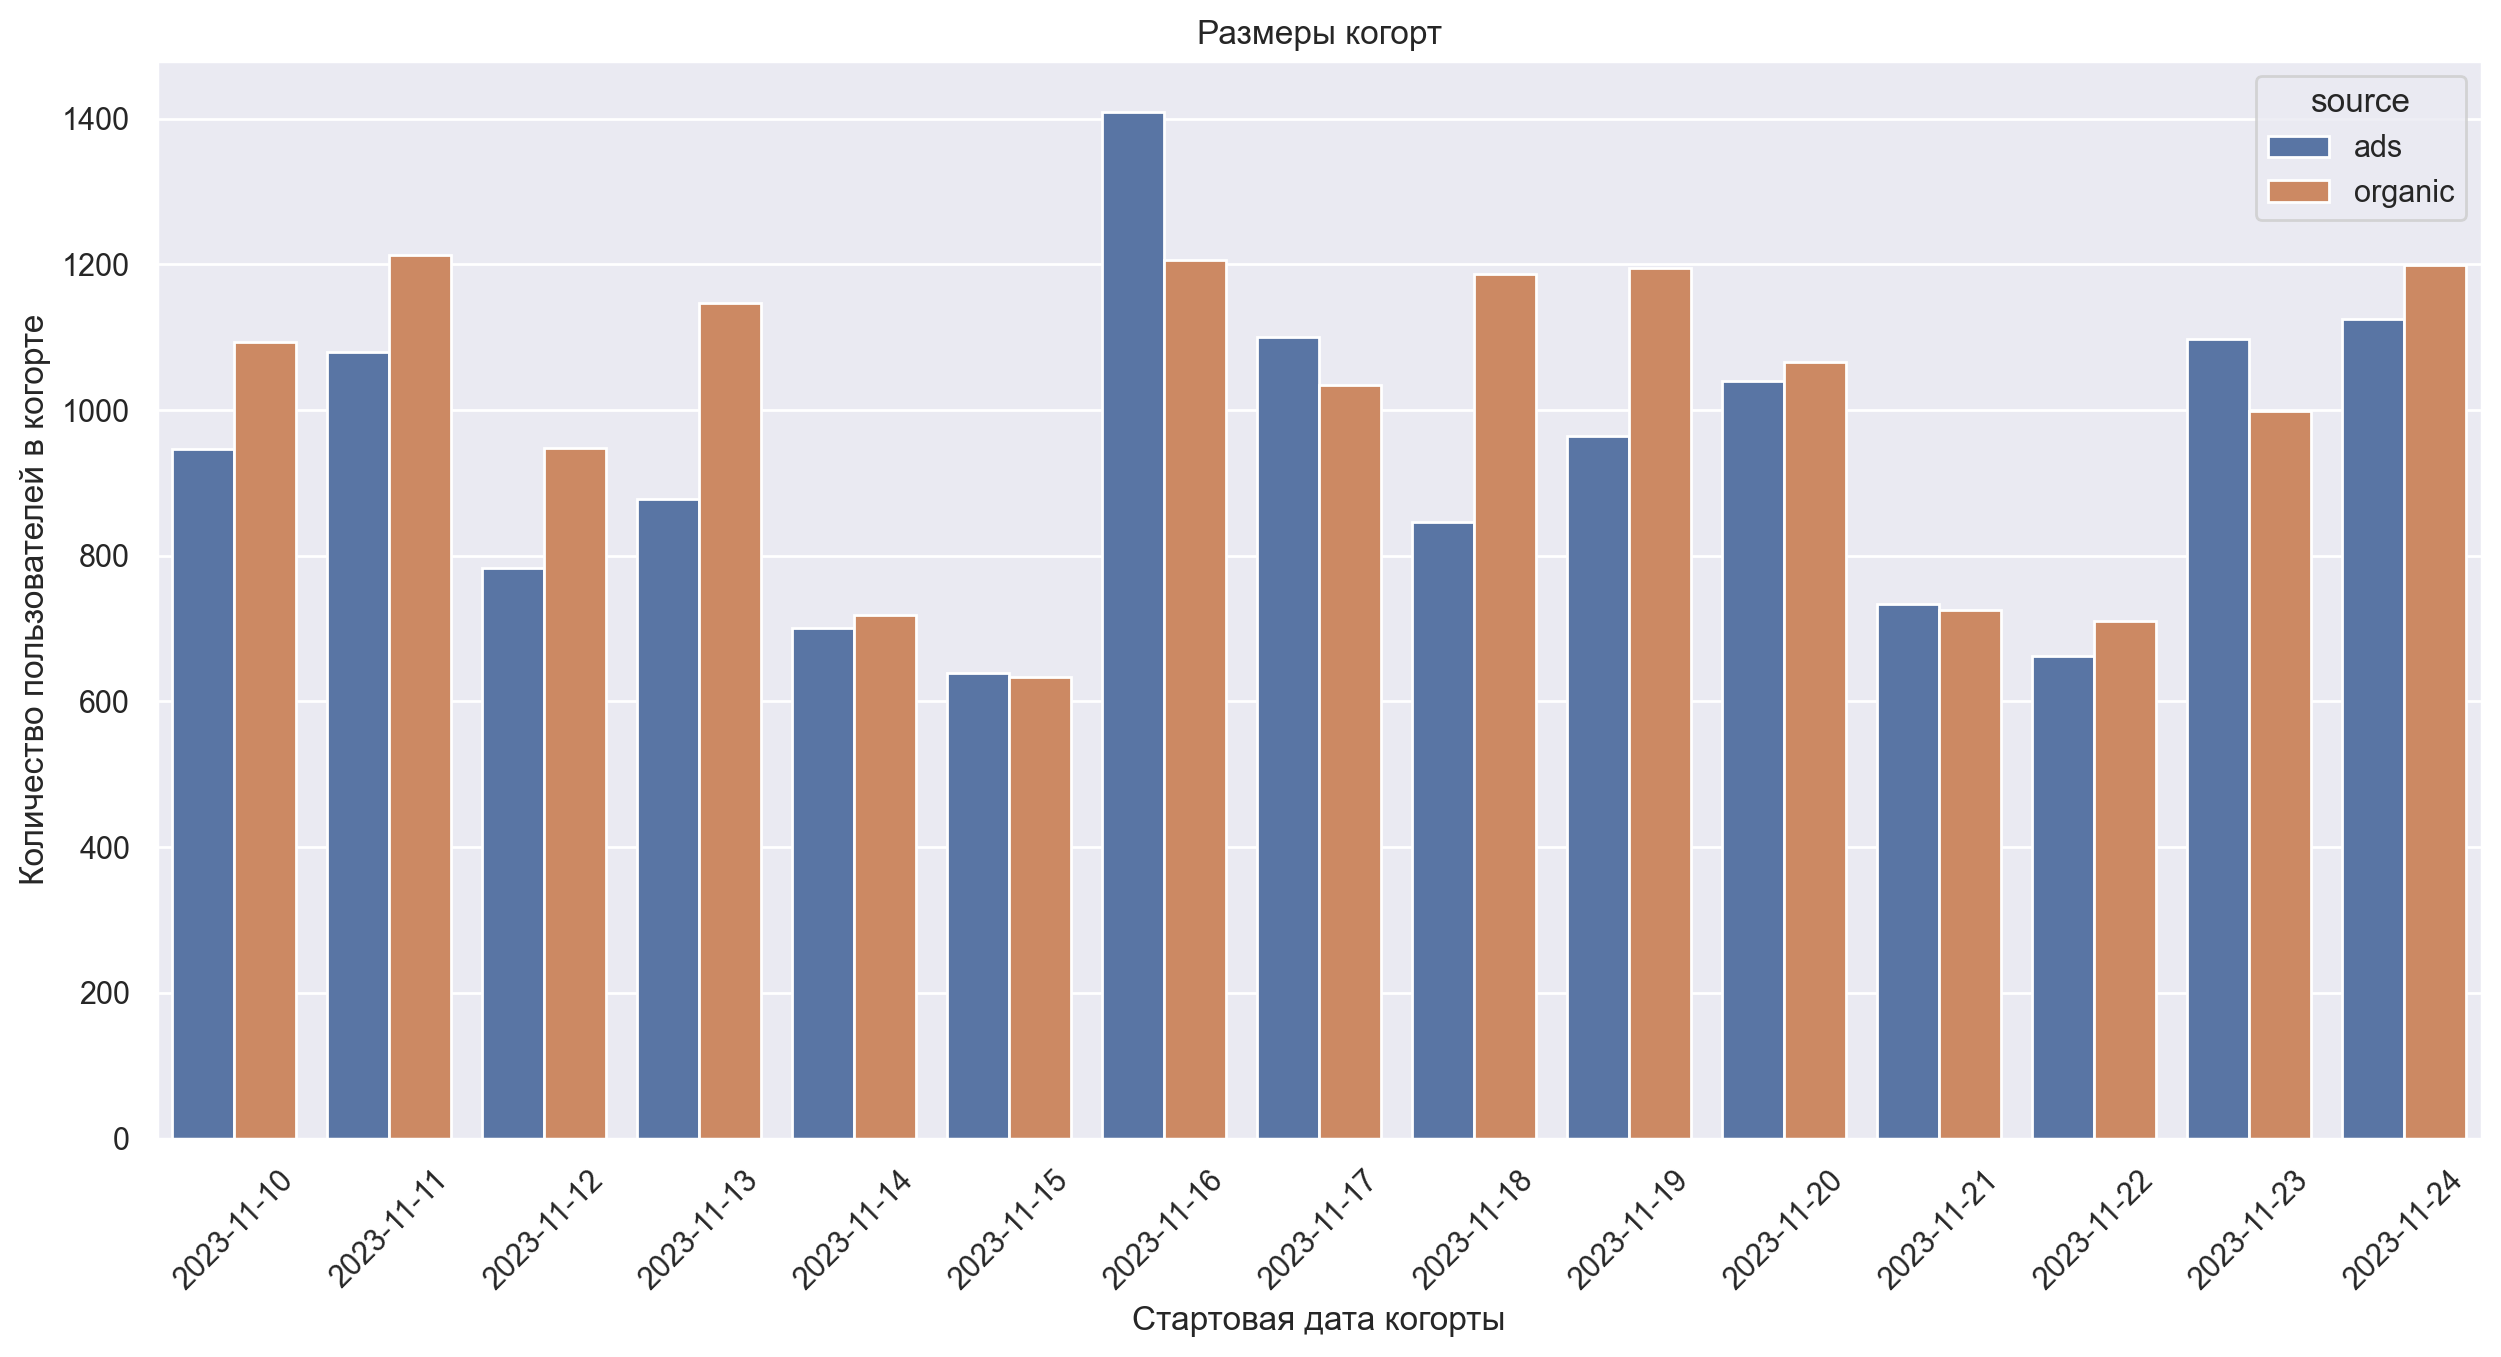

In [7]:
# построим барплот размеров наших когорт
sns.barplot(x = 'start_date', y = 'max_users_cohort', data = size_cohorts, hue = 'source')
plt.title('Размеры когорт')
plt.xlabel('Стартовая дата когорты')
plt.ylabel('Количество пользователей в когорте')
plt.xticks(rotation=45);

In [8]:
#сгруппируем по источнику привлечения средние значения когорт
mean_max_cohort = size_cohorts.groupby('source')['max_users_cohort'].mean().reset_index()
mean_max_cohort

,source,max_users_cohort
0,ads,934
1,organic,"1,005"


**На графике и по нашей группировке мы видим, что размеры когорт органических пользователей в среднем больше, чем рекламных. В среднем к нам в приложение приходят 1005 пользователей из органики, и 934 - из рекламы.**

**Сгруппируем наши данные по среднему значению наших пользователей**

In [9]:
mean_abs_users_day = df.groupby(['number_day', 'source'])['count_users'].mean().reset_index()
mean_abs_users_day['count_users'] = round(mean_abs_users_day['count_users'])
mean_abs_users_day

,number_day,source,count_users
0,0,ads,934
1,0,organic,"1,005"
2,1,ads,336
3,1,organic,443
4,2,ads,325
...,...,...,...
57,28,organic,143
58,29,ads,73
59,29,organic,138
60,30,ads,72


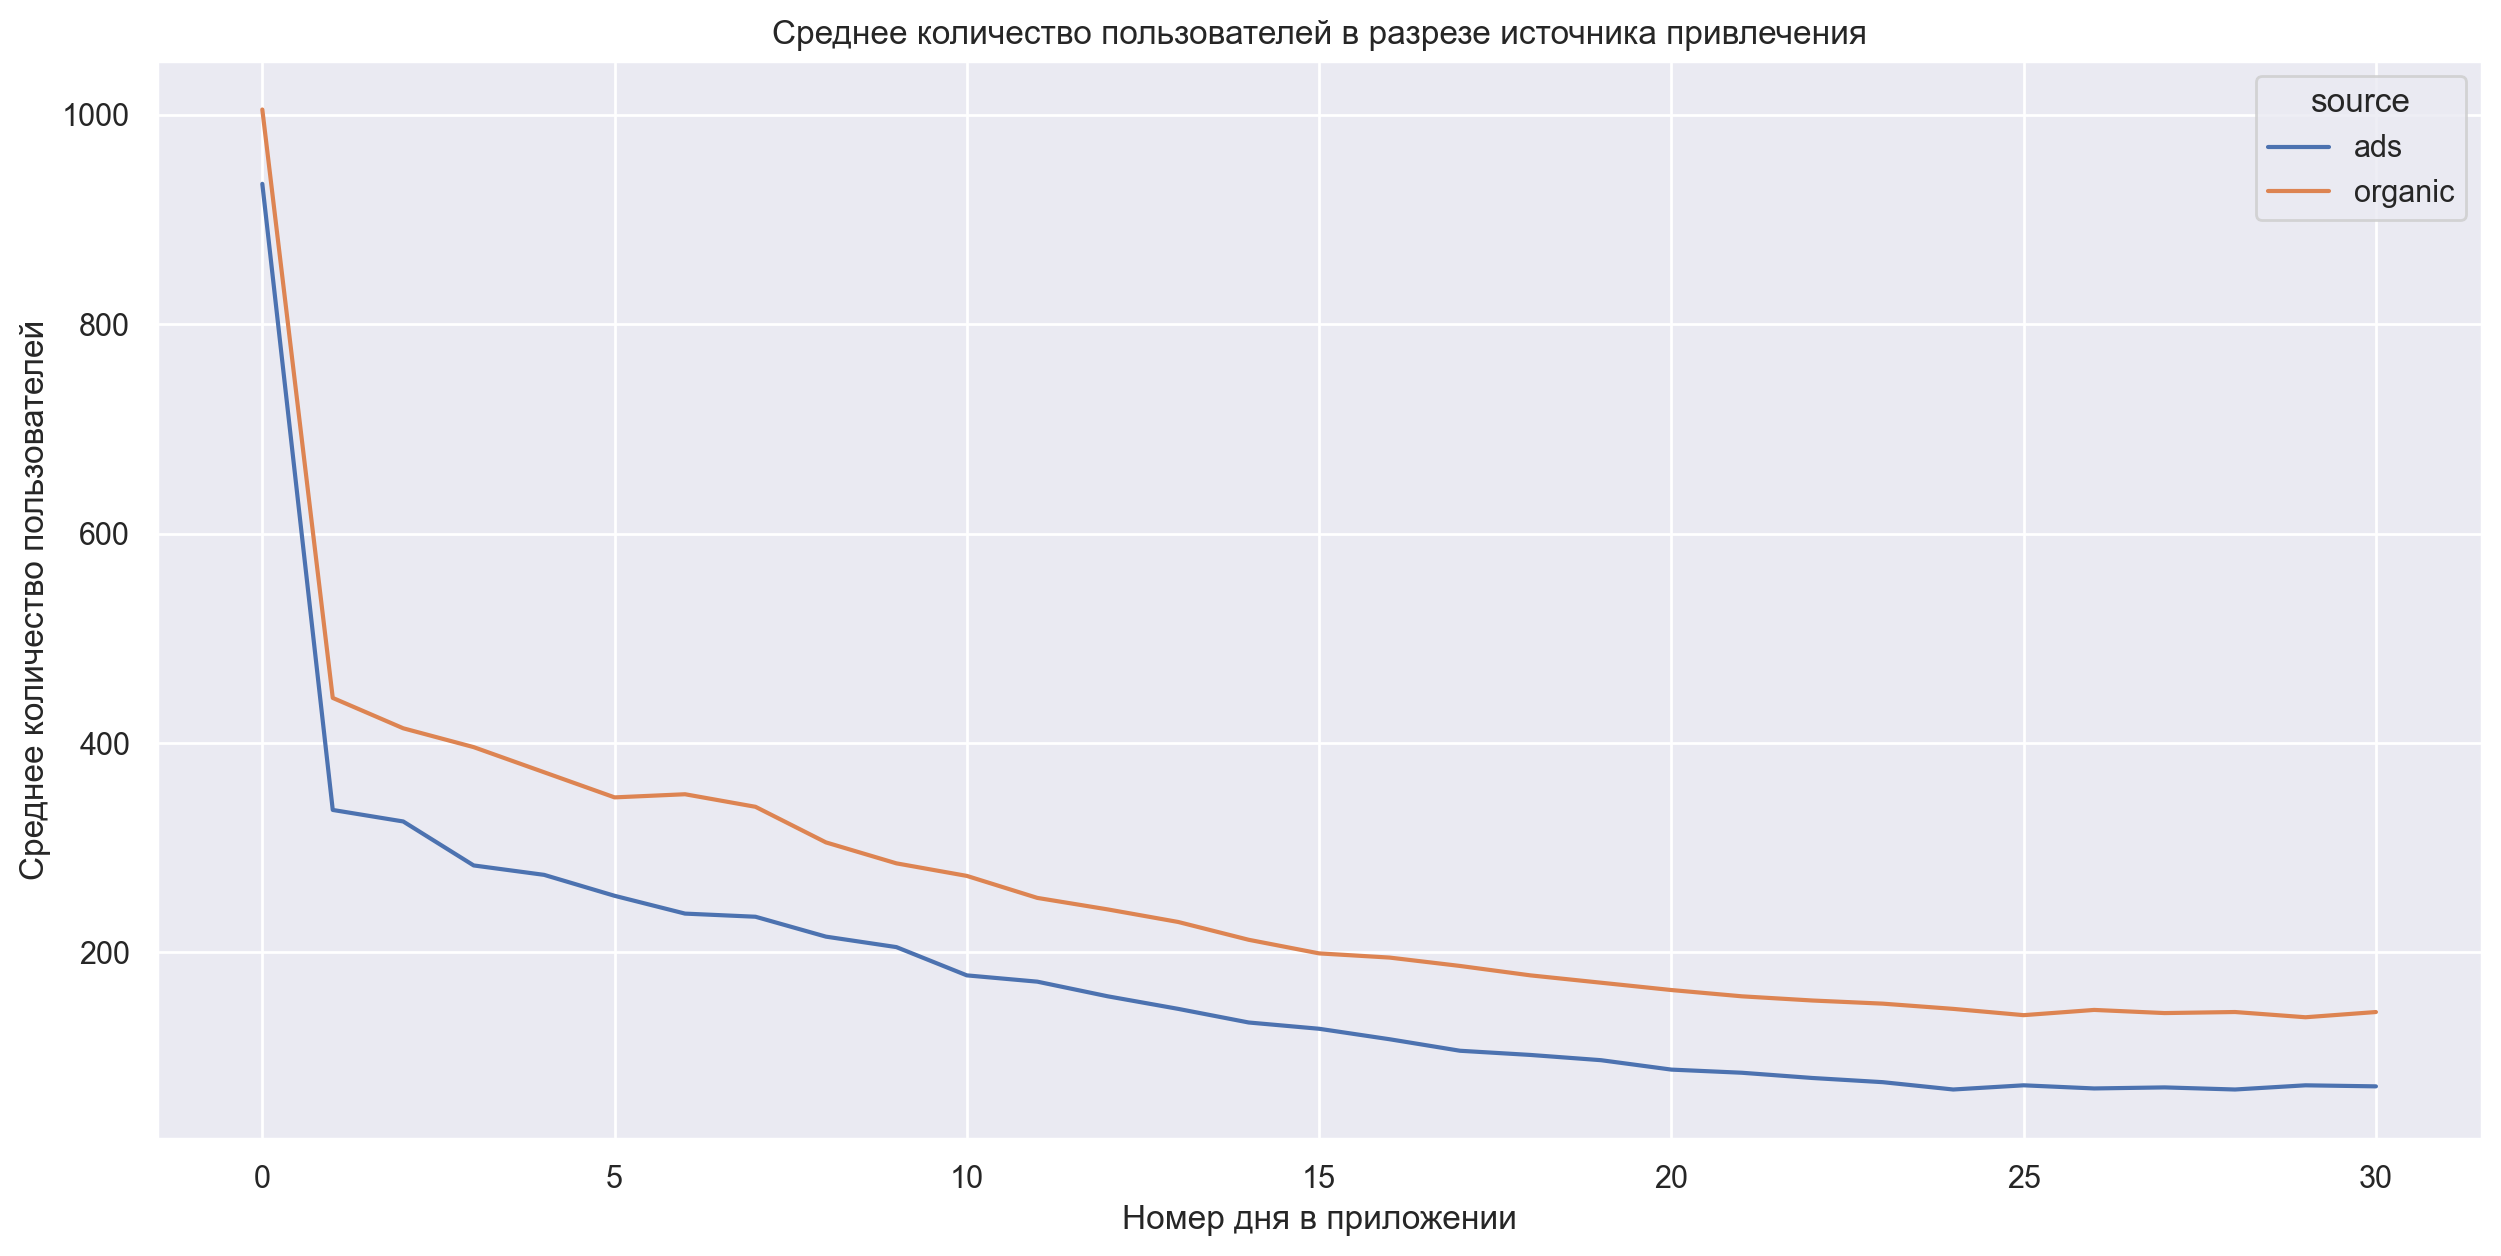

In [10]:
#построим линейный график для среднего количества пользователей в каждый день
ax = sns.lineplot(data=mean_abs_users_day, x='number_day', y = 'count_users', hue = 'source')
plt.title('Среднее количество пользователей в разрезе источника привлечения')
plt.xlabel('Номер дня в приложении')
plt.ylabel('Среднее количество пользователей');

In [11]:
#создадим сводную таблицу и сравним retention 1,7,14,21 и 30 дня
_ = mean_abs_users_day.query('number_day in (0,1,7,14,21,30)').pivot_table(
    index='number_day', columns='source', values='count_users', aggfunc='max')
_

source,ads,organic
number_day,,
0,934,"1,005"
1,336,443
7,234,339
14,133,212
21,85,158
30,72,143


**Мы видим, что органических пользователей на каждый день в приложении остается больше, чем рекламных. Дальше посмотрим на retention в процентах**

In [12]:
#сгруппируем средний retention по номеру дня и источнику
mean_retention_users_day = df.groupby(['number_day', 'source'])['retention_rate'].mean().reset_index()
mean_retention_users_day['retention_rate'] = round(mean_retention_users_day['retention_rate'])
mean_retention_users_day

,number_day,source,retention_rate
0,0,ads,100
1,0,organic,100
2,1,ads,35
3,1,organic,43
4,2,ads,34
...,...,...,...
57,28,organic,14
58,29,ads,8
59,29,organic,13
60,30,ads,8


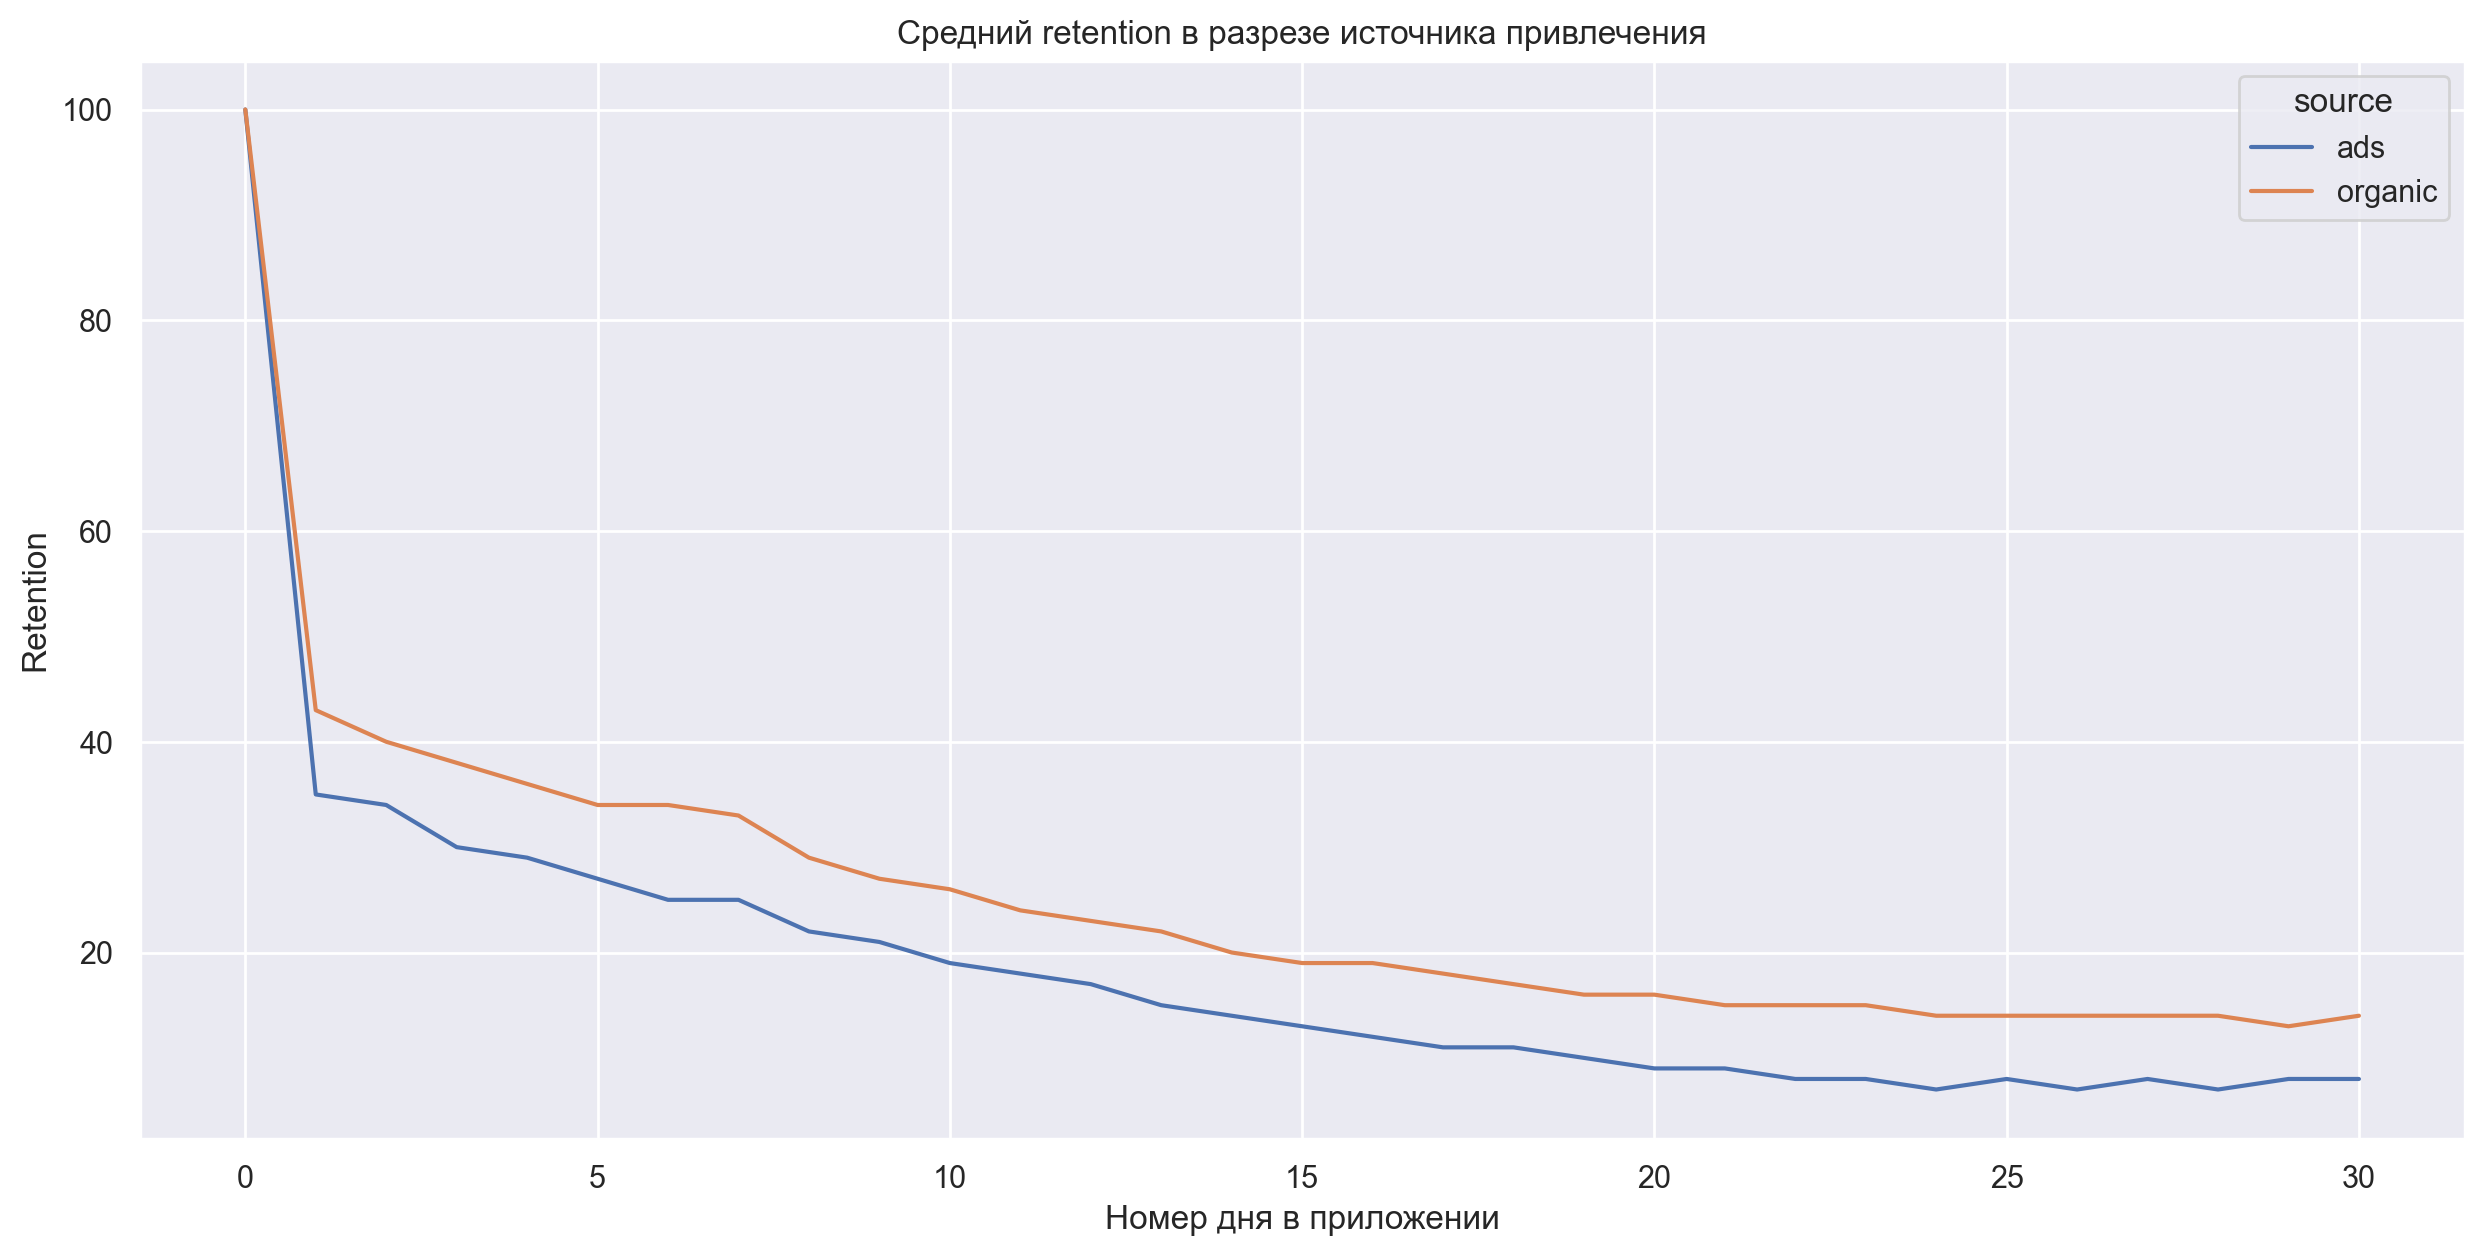

In [13]:
#построим линейный график
ax = sns.lineplot(data=mean_retention_users_day, x='number_day', y = 'retention_rate', hue = 'source')
plt.title('Средний retention в разрезе источника привлечения')
plt.xlabel('Номер дня в приложении')
plt.ylabel('Retention');

In [14]:
#создадим сводную таблицу и сравним retention 1,7,14,21 и 30 дня
_ = mean_retention_users_day.query('number_day in (0,1,7,14,21,30)').pivot_table(
    index='number_day', columns='source', values='retention_rate', aggfunc='max')
_

source,ads,organic
number_day,,
0,100,100
1,35,43
7,25,33
14,14,20
21,9,15
30,8,14


Ответим на вопрос, который мы задавали в начале - **отличается ли характер использования приложения у этих групп пользователей?**

**Анализируя показатели retention, мы видим, что в процентном соотношении в среднем органических пользователей остается в приложении больше, чем рекламных. Это разница заметна для каждого дня в приложении**
- на 1 день - разница в 8 п.п.
- на 7 день - разница в 8 п.п.
- на 14 день - разница в 6 п.п.
- на 21 день - разница в 6 п.п.
- на 30 день - разница в 6 п.п.

**Следовательно, органические пользователи для нас более ценны, поскольку остаются с нами больше**

## Задание 2. Анализ Retention маркетинговой акции 7 ноября.

**Для сравнения выгрузим данные за две недели - с 6 по 19 ноября. Для каждой когорты возьмем 30 дней.**

In [15]:
#формулируем запрос

q = """
SELECT start_date, action_date, number_day, count_users, max_users_cohort, 
       ROUND(count_users / max_users_cohort * 100 ,1) AS retention_rate
FROM
(
    SELECT start_date, action_date, number_day, source, count_users,
           MAX(count_users) OVER(PARTITION BY start_date, source) AS max_users_cohort
    FROM (
        SELECT start_date, action_date, (action_date - start_date) as number_day,  source, COUNT(DISTINCT user_id) AS count_users
        FROM (
            SELECT user_id, source, MIN(toDate(time)) AS start_date
            FROM simulator_20231113.feed_actions
            GROUP BY user_id, source) AS a1
        JOIN
            (SELECT user_id, toDate(time) AS action_date
            FROM simulator_20231113.feed_actions) AS a2 USING(user_id)
        WHERE source = 'ads'
        GROUP BY start_date, action_date, source, number_day 
        HAVING start_date BETWEEN '2023-11-06' AND '2023-11-19'
        AND number_day <= 30
        ORDER BY start_date) AS a3)
ORDER BY start_date, action_date        
"""

# сохраняем запрос в переменной df
df = ph.read_clickhouse(q, connection=connection)

In [16]:
df.head(10)

,start_date,action_date,number_day,count_users,max_users_cohort,retention_rate
0,2023-11-06,2023-11-06,0,946,946,100
1,2023-11-06,2023-11-07,1,400,946,42
2,2023-11-06,2023-11-08,2,368,946,39
3,2023-11-06,2023-11-09,3,342,946,36
4,2023-11-06,2023-11-10,4,342,946,36
5,2023-11-06,2023-11-11,5,335,946,35
6,2023-11-06,2023-11-12,6,285,946,30
7,2023-11-06,2023-11-13,7,281,946,30
8,2023-11-06,2023-11-14,8,261,946,28
9,2023-11-06,2023-11-15,9,244,946,26


In [17]:
#приведем даты в нужный формат
df['start_date'] = df['start_date'].dt.date
df['action_date'] = df['action_date'].dt.date

**Посмотрим на размеры наших когорт**

In [18]:
df.groupby('start_date')['max_users_cohort'].max().reset_index()

,start_date,max_users_cohort
0,2023-11-06,946
1,2023-11-07,2592
2,2023-11-08,393
3,2023-11-09,823
4,2023-11-10,947
5,2023-11-11,1080
6,2023-11-12,783
7,2023-11-13,878
8,2023-11-14,701
9,2023-11-15,639


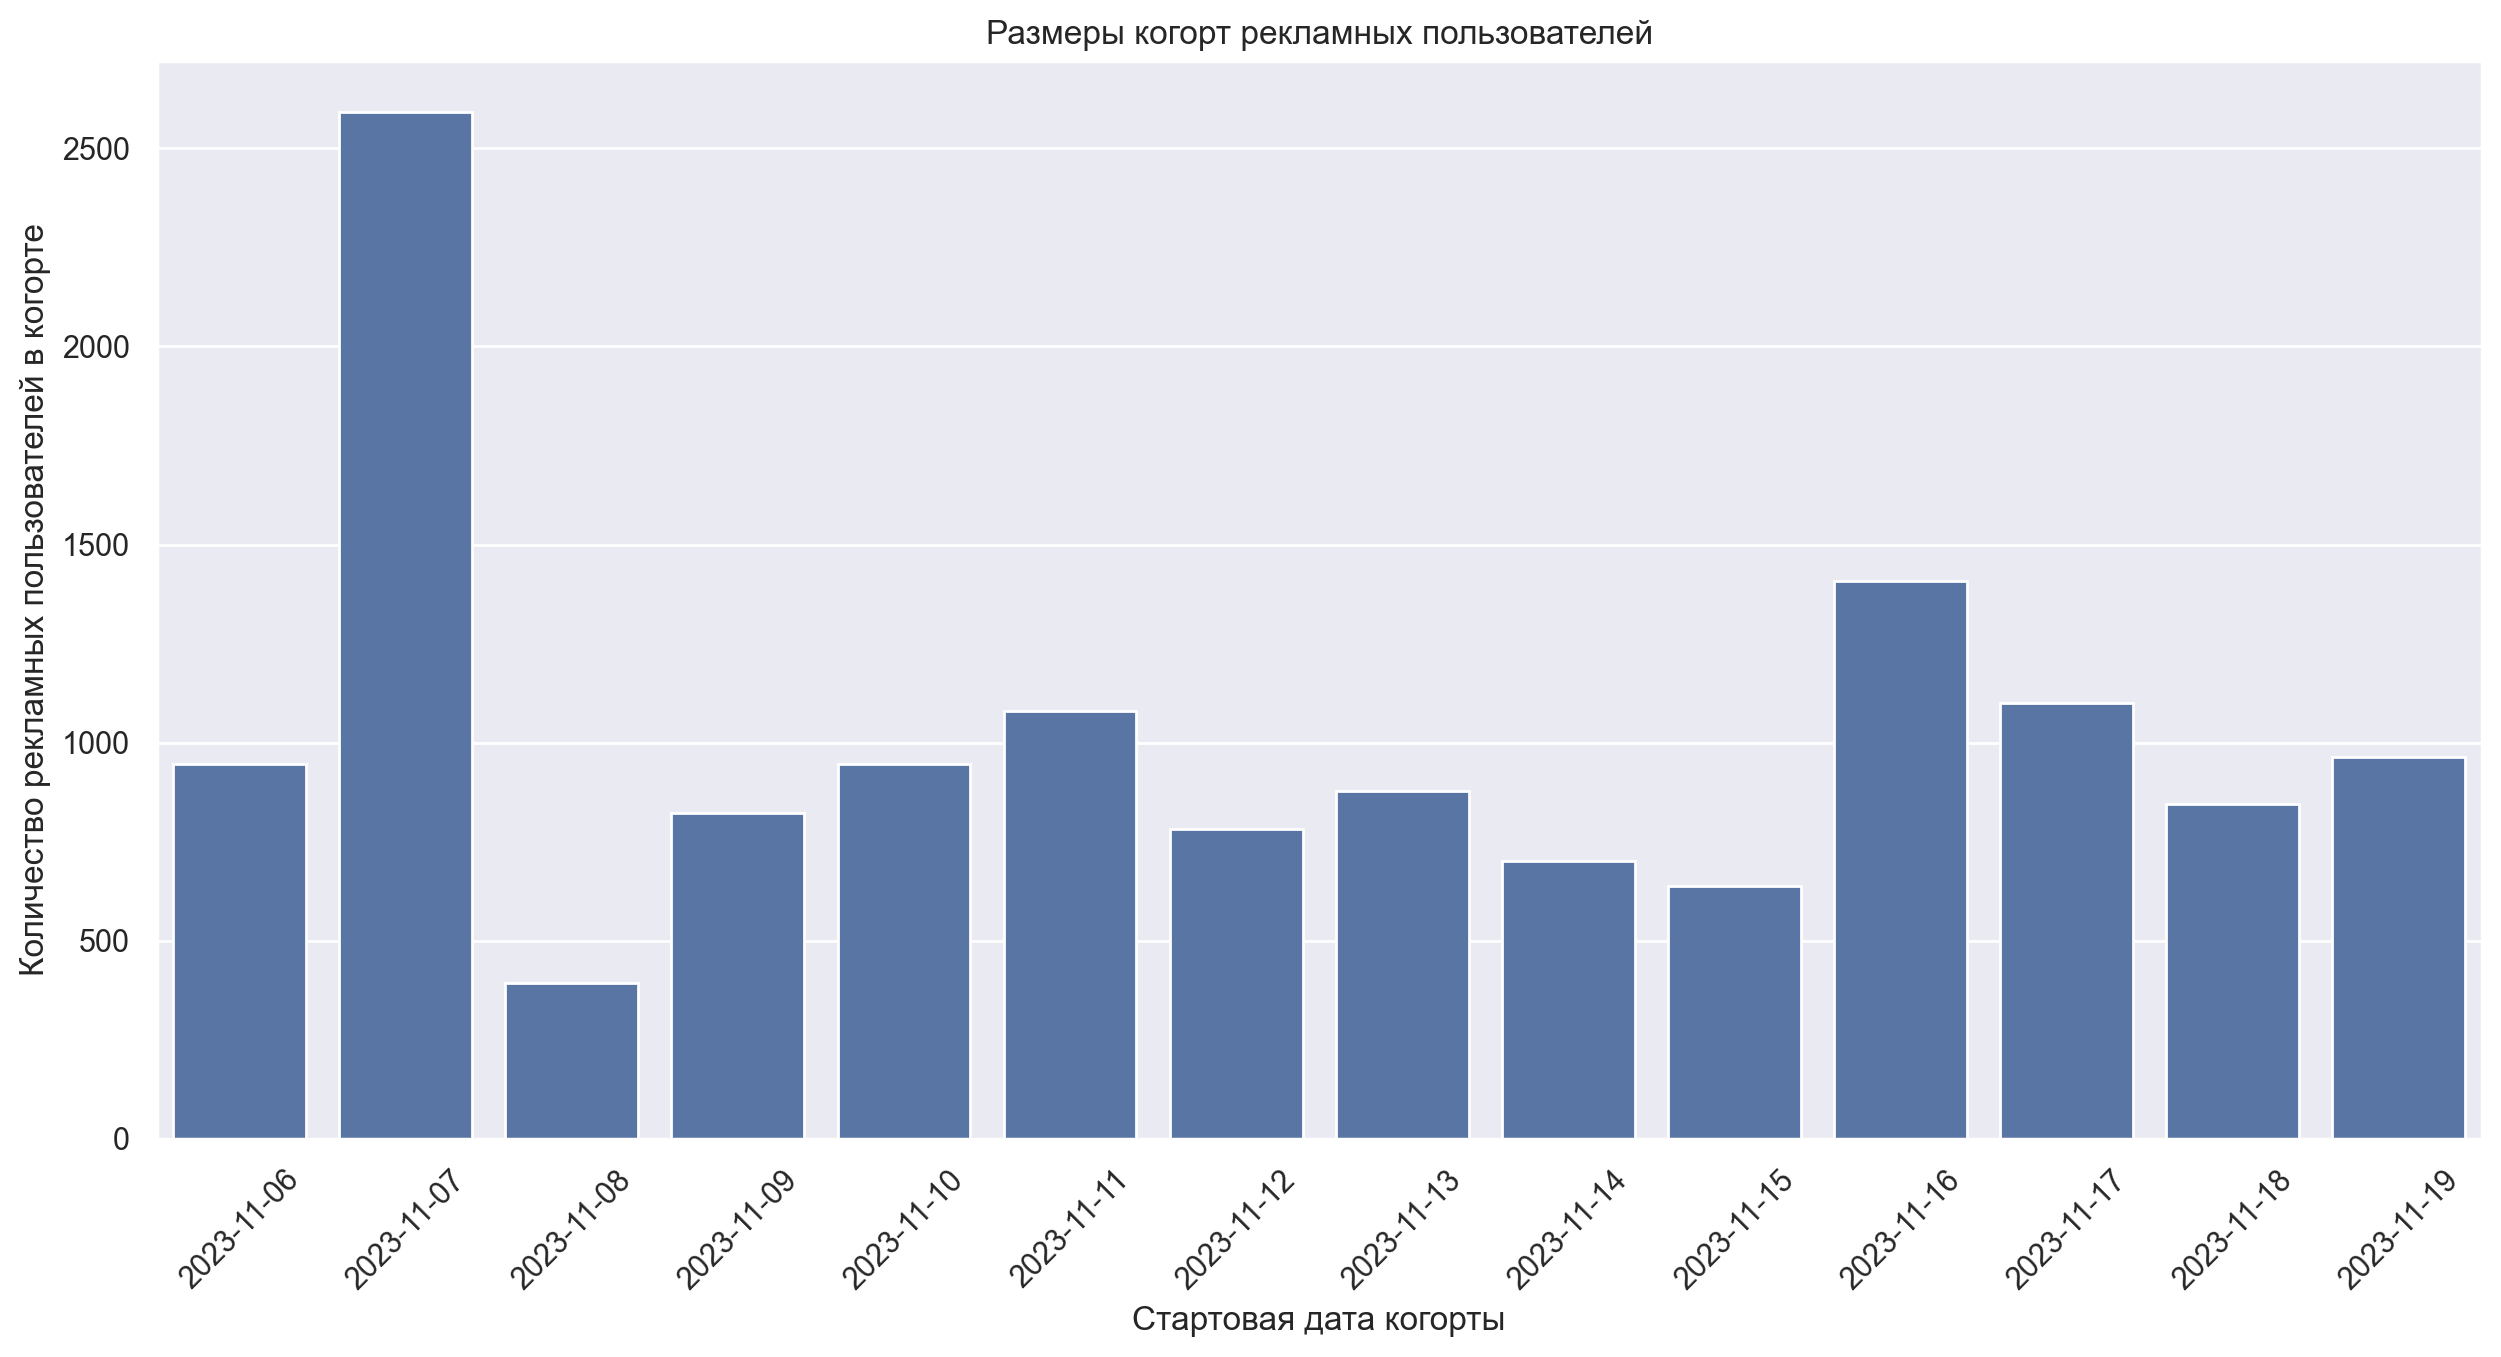

In [19]:
# построим барплот размеров наших когорт
sns.barplot(x = 'start_date', y = 'max_users_cohort', data = df)
plt.title('Размеры когорт рекламных пользователей')
plt.xlabel('Стартовая дата когорты')
plt.ylabel('Количество рекламных пользователей в когорте')
plt.xticks(rotation=45);

**Мы видим, что 7 ноября рекламных пользователей пришло почти в 2,5 раза больше, чем в остальные дни.**

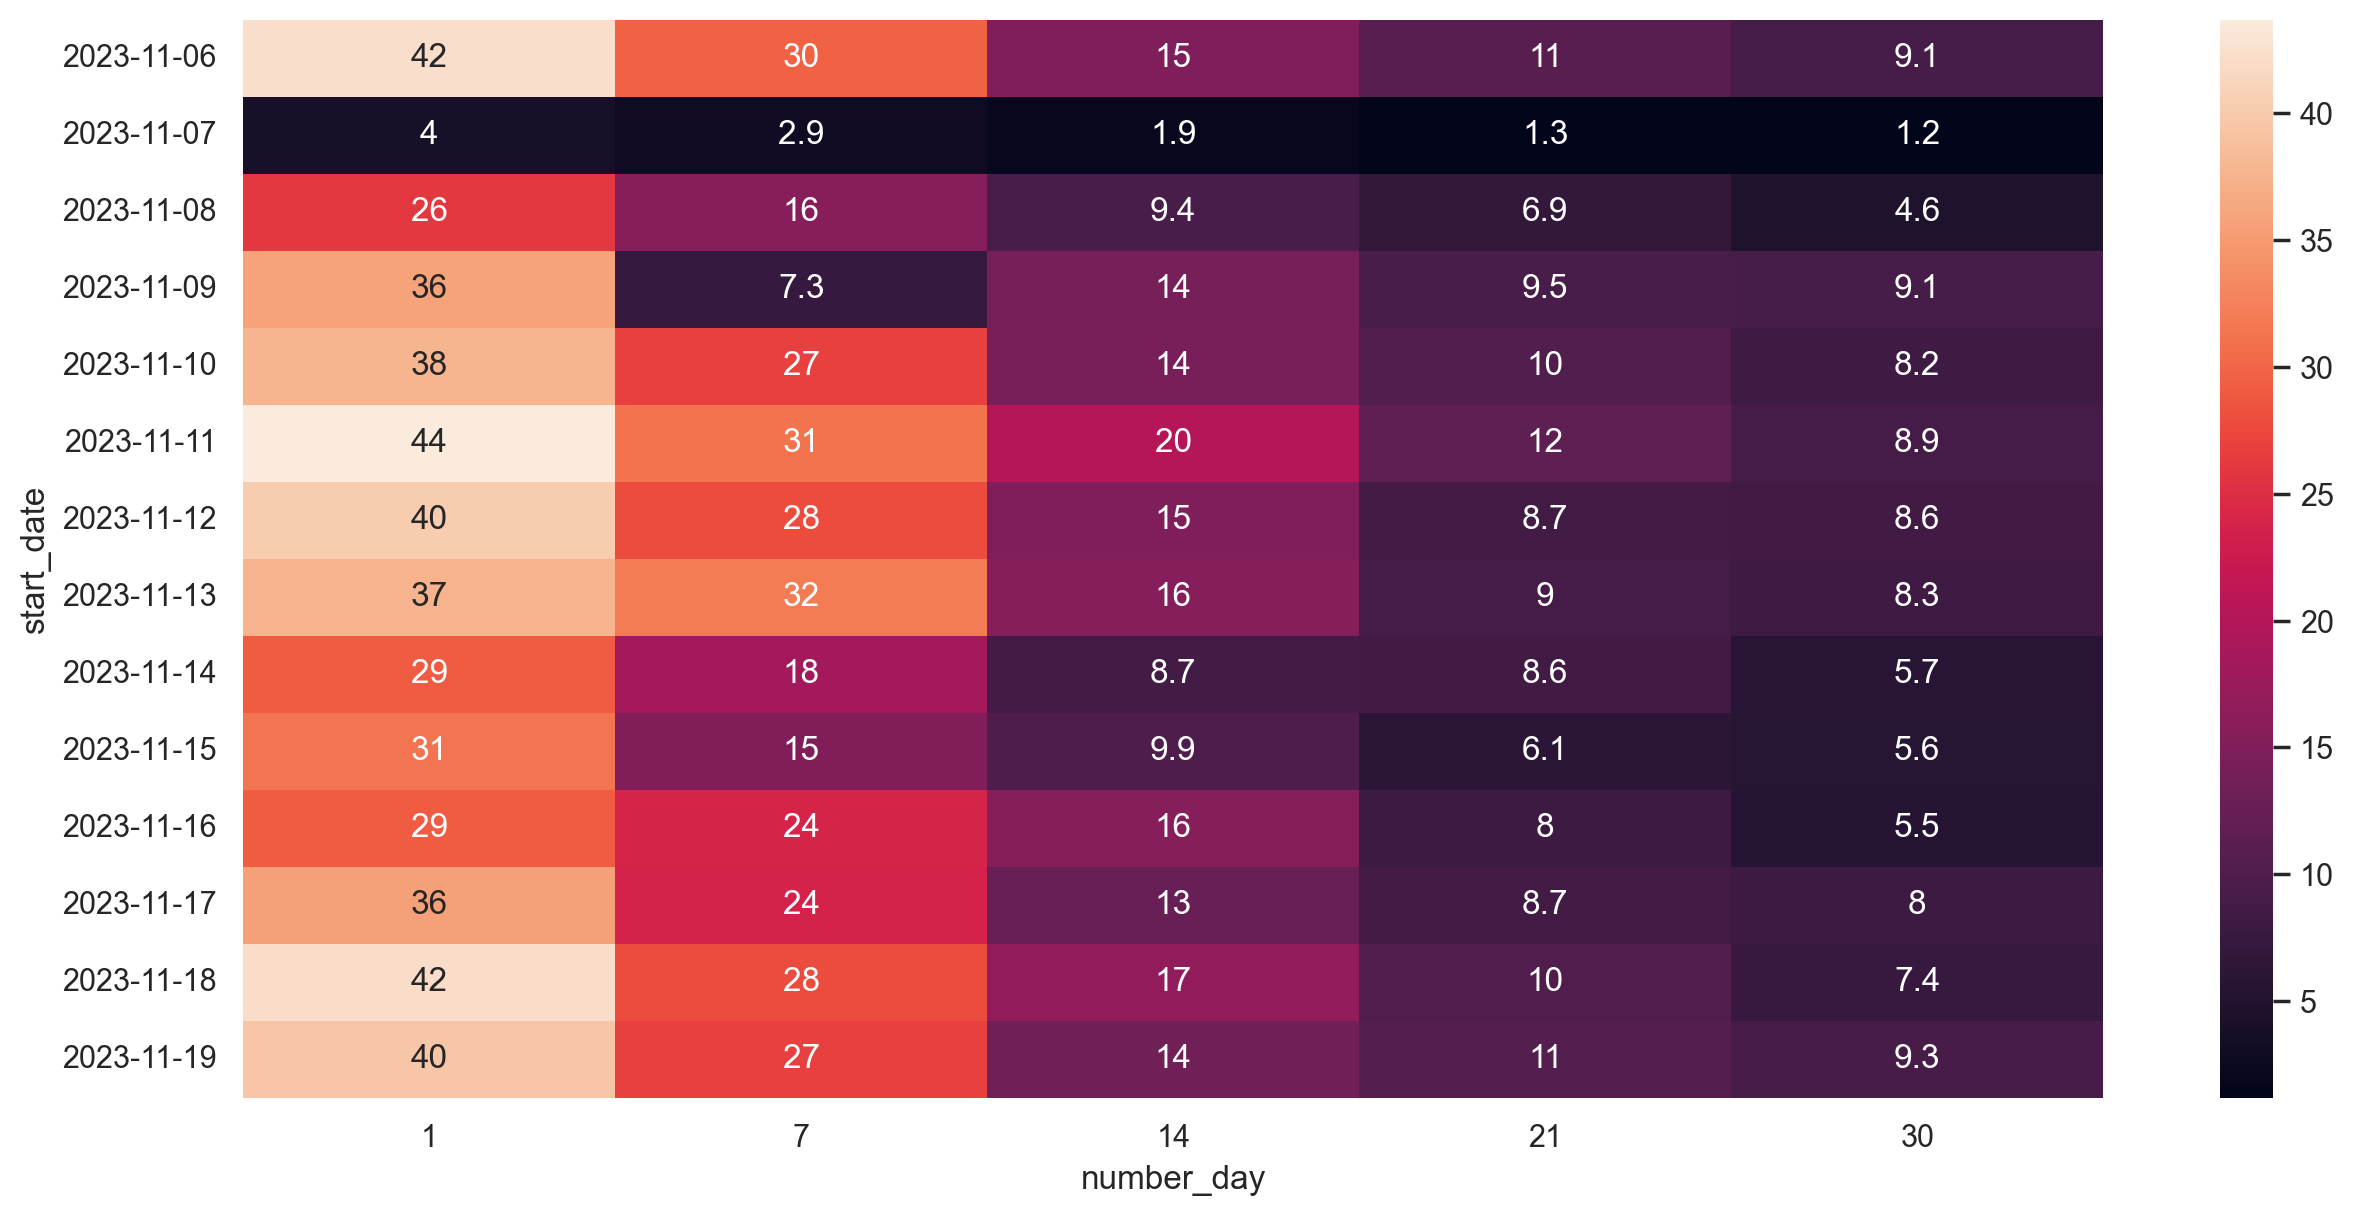

In [20]:
#сгруппируем средний retention по номеру дня и источнику
mean_retention_pivot = df.query('number_day in (1,7,14,21,30)') \
                            .pivot_table(index= 'start_date', 
                                      columns='number_day', 
                                      values = 'retention_rate',
                                      aggfunc = 'max')

sns.heatmap(mean_retention_pivot, annot=True);

**По тепловой карте мы видим, что наше приложение слабо удерживало пользователей, привлеченных 7 ноября. На 14 день осталось 1.9% пользователей, на 30 день - 1.2% пользователей. Это сильно меньше значений остальных когорт. Поэтому признаем маркетинг от 7 ноября неэффективным**

## Вывод

В начале нашего задания мы себе задавали два вопроса: 
1. Отличается ли характер использования приложения у рекламных и органических пользователей?
2. Что стало с рекламными пользователями от 7 ноября в дальнейшем, как часто они продолжают пользоваться приложением?

В ходе нашего исследования формируем следующие выводы:
1. Анализируя показатели retention, мы видим, что в процентном соотношении **в среднем органических пользователей остается в приложении больше, чем рекламных.** Это разница заметна для каждого дня в приложении:

- на 1 день - разница в 8 п.п.
- на 7 день - разница в 8 п.п.
- на 14 день - разница в 6 п.п.
- на 21 день - разница в 6 п.п.
- на 30 день - разница в 6 п.п.

**Следовательно, органические пользователи для нас более ценны, поскольку остаются с нами больше**

2. **Маркетинг от 7 ноября - неэффективный**, потому что на 14 день в приложении остается всего 1.9% пользователей, что примерно на 15 п.п. меньше, чем для остальных когорт. 